<a href="https://colab.research.google.com/github/MohrezSheikh/Deep-Transfer-Learning-with-CNN-for-EEG-signals-in-diagnosing-Schizophrenia-patients./blob/master/CNN_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install mne
!pip install pyedflib
!pip install pywt
!pip install keras
!pip install tensorflow
!pip install matplotlib
!pip install scikeras

import os
import numpy as np
import pandas as pd
import mne
import pywt
import matplotlib
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from google.colab import drive
from PIL import Image
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, LSTM
from keras.preprocessing import image
from tensorflow.keras.preprocessing import image
from keras.utils import to_categorical
import tensorflow as tf

from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping

from keras.layers import Reshape
from tensorflow.keras.layers import LSTM, Dense, Flatten
from sklearn.model_selection import train_test_split


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 29.5 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement pywt (from versions: none)
ERROR: No matching distribution found for pywt


In [2]:
# images path
healthy_save_path = '/content/drive/MyDrive/eeg/NewHealthy'
schizophrenia_save_path = '/content/drive/MyDrive/eeg/NewSchizophrenia'

In [3]:
healthy_folder = healthy_save_path
schizophrenia_folder = schizophrenia_save_path

# Define functions for loading and processing images
def load_images(folder):
    images = []
    labels = []
    for filename in os.listdir(folder):
        if filename.endswith(".png"):
           # best : target_size=(224, 224) run it in IDE
            img =image.load_img(os.path.join(folder, filename), target_size=(224, 224))
            img_array = image.img_to_array(img) / 255.0
            images.append(img_array)
            labels.append(0 if folder == healthy_folder else 1)
    return np.array(images), np.array(labels)

X_healthy, y_healthy = load_images(healthy_folder)
X_schizophrenia, y_schizophrenia = load_images(schizophrenia_folder)

# Merge datasets
X = np.concatenate((X_healthy, X_schizophrenia), axis=0)
y = np.concatenate((y_healthy, y_schizophrenia), axis=0)

# Shuffle the dataset
indices = np.arange(X.shape[0])
np.random.shuffle(indices)
X = X[indices]
y = y[indices]
print('X Shape: ', X.shape)

X Shape:  (1142, 224, 224, 3)


In [4]:
input_shape = (224, 224, 3)
# Divide training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [5]:
from tensorflow import keras
from keras import layers

# num_classes = len(class_names)

simple_model = tf.keras.Sequential([
  layers.Conv2D(32, 3, activation='relu'),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, activation='relu'),
  layers.Conv2D(64, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, activation='relu'),
  layers.Conv2D(128, 3, activation='relu'),
  layers.Conv2D(128, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(512, activation='relu'),
  layers.Dense(512, activation='relu'),
  layers.Dense(2, activation='softmax')
])

opt = keras.optimizers.Adam(learning_rate=0.0001)
simple_model.compile(optimizer=opt, loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])


In [6]:
simple_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=60, batch_size=128)

Epoch 1/60
7/7 [==============================] - 29s 1s/step - loss: 0.6907 - accuracy: 0.5482 - val_loss: 0.6890 - val_accuracy: 0.5481
Epoch 2/60
7/7 [==============================] - 2s 335ms/step - loss: 0.6890 - accuracy: 0.5482 - val_loss: 0.6882 - val_accuracy: 0.5481
Epoch 3/60
7/7 [==============================] - 2s 352ms/step - loss: 0.6889 - accuracy: 0.5482 - val_loss: 0.6887 - val_accuracy: 0.5481
Epoch 4/60
7/7 [==============================] - 3s 409ms/step - loss: 0.6884 - accuracy: 0.5482 - val_loss: 0.6869 - val_accuracy: 0.5481
Epoch 5/60
7/7 [==============================] - 2s 340ms/step - loss: 0.6853 - accuracy: 0.5482 - val_loss: 0.6864 - val_accuracy: 0.5481
Epoch 6/60
7/7 [==============================] - 2s 338ms/step - loss: 0.6891 - accuracy: 0.5482 - val_loss: 0.6820 - val_accuracy: 0.5481
Epoch 7/60
7/7 [==============================] - 2s 343ms/step - loss: 0.6818 - accuracy: 0.5945 - val_loss: 0.6812 - val_accuracy: 0.6064
Epoch 8/60
7/7 [======

In [7]:
simple_model.save('simple_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [8]:
simple_model = keras.models.load_model('simple_model.h5')

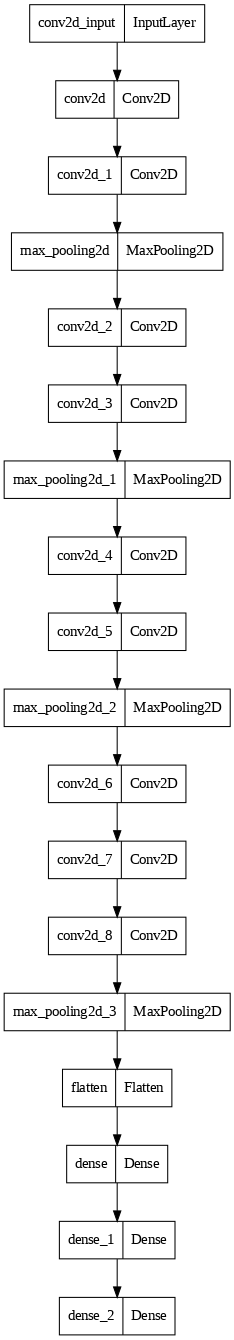

In [9]:
tf.keras.utils.plot_model(simple_model, dpi=75)

11/11 [==============================] - 0s 39ms/step


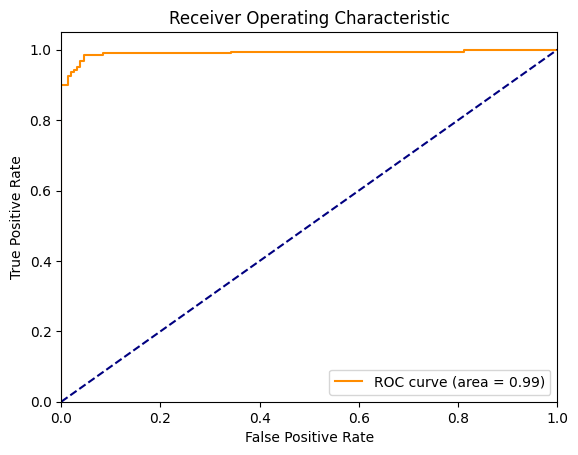

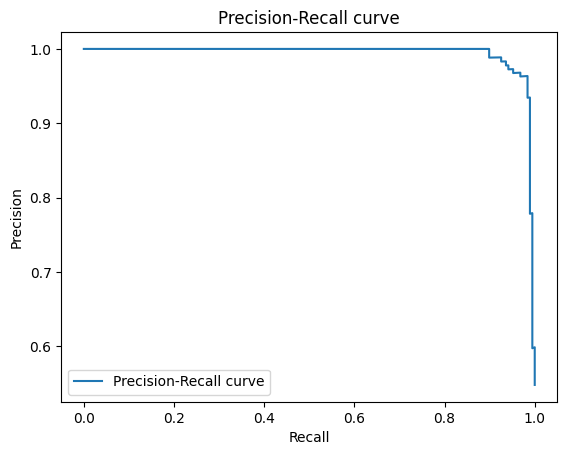

Accuracy: 0.9416909620991254
AUC Score: 0.9910432395332875
Precision: 0.9117647058823529
Recall: 0.9893617021276596


In [23]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, accuracy_score, roc_auc_score, precision_score, recall_score

# Make predictions on the test set
y_pred_proba = simple_model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)

# Calculate metrics
fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred_proba[:, 1])
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_pred_proba[:, 1])

roc_auc = auc(fpr, tpr)
accuracy = accuracy_score(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_pred_proba[:, 1])
precision_score = precision_score(y_test, y_pred)
recall_score = recall_score(y_test, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Plot Precision-Recall curve
plt.figure()
plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc="lower left")
plt.show()

# Print metrics
print("Accuracy:", accuracy)
print("AUC Score:", auc_score)
print("Precision:", precision_score)
print("Recall:", recall_score)